Ensure `nvidia-smi` works.

Try running `!nvidia-smi` to check, else download [CUDA toolkit](https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local)

In [10]:
import torch
torch.cuda.is_available()

False

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
# import urllib.request
import sys
import torch
import time
# import datetime

from torchvision import transforms
from PIL import Image
# from moviepy.editor import *

# %matplotlib inlines

In [3]:
# Change directory to "/yolov7"
os.chdir("yolov7")

In [ ]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load models
print("Loading model: ", "yolov7-tiny...")
weights_path = "yolov7-w6-pose.pt"
model = torch.load(weights_path, map_location=device, weights_only=False)['model']
print("Model loaded.")

model.float().eval()

if torch.cuda.is_available():
    # half() turns predictions into float16 tensors --> significantly lowers inference time
    model.half().to(device)


Loading model:  yolov7-tiny...
Model loaded.


In [ ]:
# Main inference
def infer(image):
    image = letterbox(image, 960, 
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model(image)

    return output, image


# Adding keypoints to original image
def draw_keypoints(output, image, confidence=0.25, threshold=0.65):
    """
    Draw YoloV7 pose keypoints
    """
    output = non_max_suppression_kpt(
        output,
        confidence,  # Confidence Threshold
        threshold,  # IoU Threshold
        nc=model.yaml['nc'],  # Number of Classes
        nkpt=model.yaml['nkpt'],  # Number of Keypoints
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)

    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    return nimg

Inferencing image input...
Inference complete.


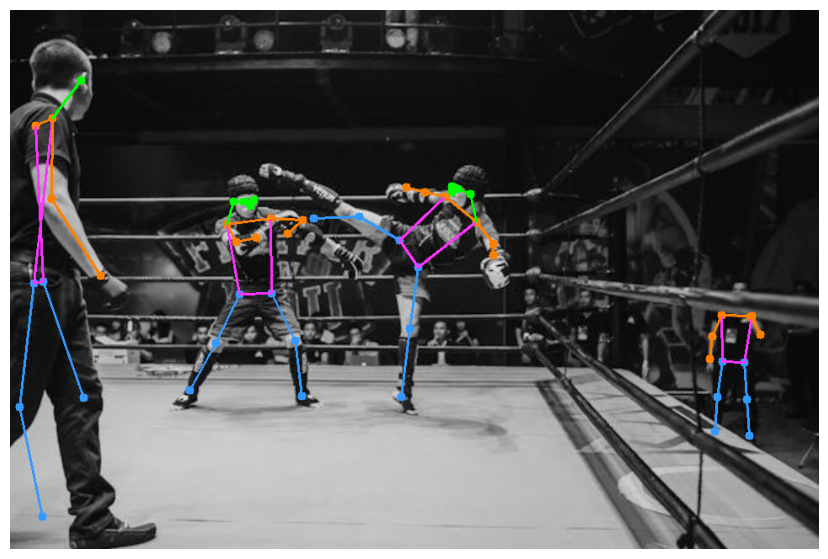

In [24]:
imagefile = "../test_images/boxing_grey.jpg"

print("Inferencing image input...")

output, image = infer(cv2.imread(imagefile))
pose_image = draw_keypoints(output, image, confidence=0.25, threshold=0.65)

print("Inference complete.")

plt.figure(figsize=(30, 7))
plt.axis("off")
plt.imshow(pose_image)

In [ ]:
def yoloV7_pose_video(videofile, confidence=0.25, threshold=0.65):
    start = time.time()

    # Reading video
    capture = cv2.VideoCapture(videofile)

    # Video Information
    fps = capture.get(cv2.CAP_PROP_FPS)
    total_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = total_frames / fps

    print(f"Processing video: {videofile} using confidence min = {confidence} and threshold = {threshold}")
    print(f"\nVideo duration = {duration} seconds")
    print(f"FPS = {fps}")
    print(f"Total number of frames = {total_frames}\n")

    # Capture the results frames into a video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outputvideofile = "../results/result_" + os.path.basename(videofile)
    outvideo = cv2.VideoWriter(outputvideofile, fourcc, 30.0,
                               (int(capture.get(3)), int(capture.get(4))))
    idx = 1

    while capture.isOpened():
        (ret, frame) = capture.read()

        if ret == True:
            # Print the progress every second
            if idx % fps == 1:
                nbremainframes = total_frames - idx
                pctdone = round(idx / total_frames * 100)
                print("Processed frames =", f"{idx:06}",
                      "| Number of remaining frames:", f"{nbremainframes:06}",
                      "| Done:", pctdone, "%")

            # For each frame, convert to RGB & do inference
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            output, frame = infer(frame)
            frame = draw_keypoints(output, frame, confidence, threshold)
            frame = cv2.resize(frame,
                               (int(capture.get(3)), int(capture.get(4))))

            cv2.imwrite(
                "results/videoframe_" + os.path.basename(videofile) + '_' +
                str(f"{idx:06}.jpg"), frame)
            
            # Output to video file
            outvideo.write(frame)  

        else:
            break

        idx += 1

    processed_time = round(time.time() - start)
    time_per_frame = round(processed_time / (idx - 1), 2)

    print(f"\nDone in {processed_time} seconds")
    print(f"Time per frame = {time_per_frame} seconds")
    print(f"\nSaved video: {outputvideofile}")

    capture.release()
    outvideo.release()

    return outputvideofile

In [40]:
football_vid = "../test_videos/football.mp4"
football_video = yoloV7_pose_video(football_vid)

Processing video: ../test_videos/football.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 13.1 seconds
FPS = 10.0
Total number of frames = 131.0 

Processed frames = 000001 | Number of remaining frames: 0130.0 | Done: 1 %
Processed frames = 000011 | Number of remaining frames: 0120.0 | Done: 8 %
Processed frames = 000021 | Number of remaining frames: 0110.0 | Done: 16 %
Processed frames = 000031 | Number of remaining frames: 0100.0 | Done: 24 %
Processed frames = 000041 | Number of remaining frames: 0090.0 | Done: 31 %
Processed frames = 000051 | Number of remaining frames: 0080.0 | Done: 39 %
Processed frames = 000061 | Number of remaining frames: 0070.0 | Done: 47 %
Processed frames = 000071 | Number of remaining frames: 0060.0 | Done: 54 %
Processed frames = 000081 | Number of remaining frames: 0050.0 | Done: 62 %
Processed frames = 000091 | Number of remaining frames: 0040.0 | Done: 69 %
Processed frames = 000101 | Number of remaining frames: 0030.0 | Done: 7